In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
#!kaggle datasets download -d kazanova/sentiment140

!kaggle datasets download -d selener/consumer-complaint-database
##!unzip /content/consumer-complaint-database.zip

Dataset URL: https://www.kaggle.com/datasets/selener/consumer-complaint-database
License(s): U.S. Government Works
100% 175M/176M [00:06<00:00, 39.9MB/s]
100% 176M/176M [00:06<00:00, 26.7MB/s]


In [ ]:
!unzip /content/consumer-complaint-database.zip

Archive:  /content/consumer-complaint-database.zip
  inflating: rows.csv                


In [ ]:

import pandas as pd
import numpy as np
df = pd.read_csv(r"/content/rows.csv")
df.head()

<ipython-input-3-be59f3efeae7>:3: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/content/rows.csv")


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,NaN,NaN,CURO Intermediate Holdings,TX,751XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3237964
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,Ad Astra Recovery Services Inc,LA,708XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3238479
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,ALLY FINANCIAL INC.,AZ,85205,NaN,NaN,Postal mail,05/10/2019,In progress,Yes,NaN,3238460


In [ ]:
df1 = df[['Product', 'Consumer complaint narrative']]
df1.columns = ['Product', 'Consumer complaint']

Filtering the Complaints with No text (False Complaint )

In [ ]:
df1 = df1[df1['Consumer complaint'].isna() != True]

Under Feature Engineering we do some data manipulation in order to train the model efficiently and get a better insight into the data.

In [ ]:
pd.DataFrame(df1.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Debt collection'],
       ['Student loan'],
       ['Mortgage'],
       ['Credit card or prepaid card'],
       ['Checking or savings account'],
       ['Money transfer, virtual currency, or money service'],
       ['Vehicle loan or lease'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit card'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [ ]:
# Renaming categories by using
df1.replace({'Product':
             {
              'Credit reporting': 'Repair or Credit reporting',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
            'credit repair services,Credit reporting , or other personal consumer reports':
            'Repair or Credit reporting',
             'Money transfer': 'Money transfer, virtual currency, or money service',
            'Payday loan': 'title loan,Payday ,Personal loan',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [ ]:
df2 = df1.sample(10000, random_state=1).copy()

In [ ]:
df2['category_id'] = df2['Product'].factorize()[0]

In [ ]:
df2.head()

,Product,Consumer complaint,category_id
310399,"Credit reporting, credit repair services, or o...",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, credit repair services, or o...",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,Credit card or prepaid card,I have a XXXX BIG card and made my payment whe...,3


As you see we have converted the category label into category_id we also need data to convert category_id back to the category label at the time of prediction. For this purpose, we will create a dictionary.

In [ ]:
category_id = df2[['Product', 'category_id']].drop_duplicates()
id_2_category = dict(category_id[['category_id', 'Product']].values)

Text(0.5, 0, 'Number of ocurrences')

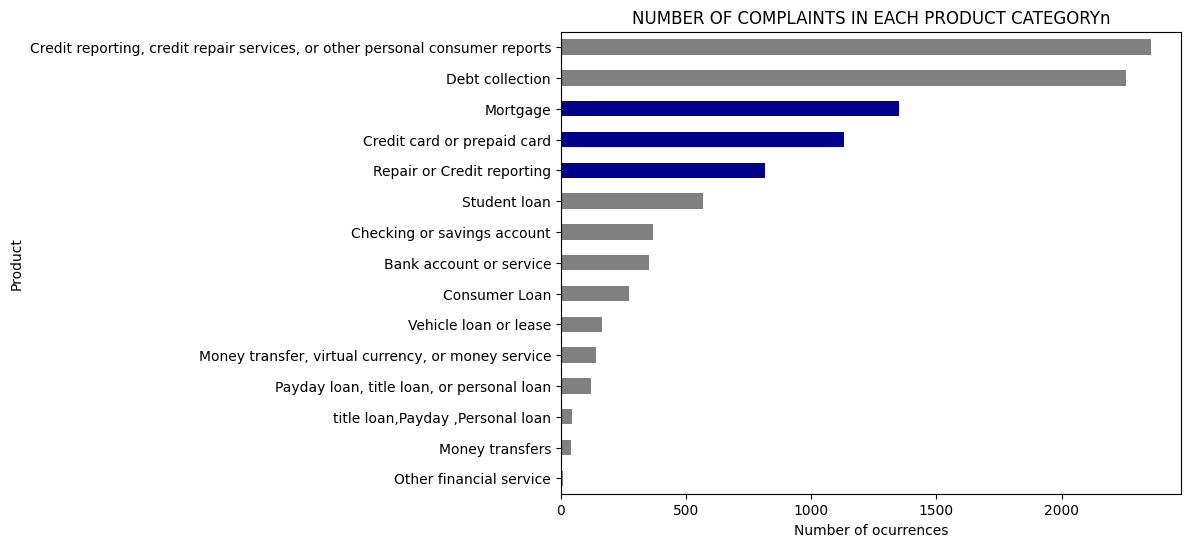

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product')['Consumer complaint'].count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORYn')
plt.xlabel('Number of ocurrences', fontsize = 10)


You can Possibly see that “credit reporting, repair and other “ have the maximum supporting records and “Other financial Services” have very few records. This shows some Possible data imbalance and this can be fixed by sampling equal records from each category/Product.

Now we need to convert the Complaint text into some vectors since the machine can’t understand the textual data. This process is called Feature Extraction.

We are going to use tf-idf Vectorizer ( Inverse Document Frequency ) for feature extraction. If you are not comfortable with Feature Engineering prefer my article.

TFIDF evaluated how important a word is to its document in a collection or group of documents.

Note: After removing punctuation, lower caseing the words we can proceed to the feature extraction step. TFIDF vectorizer can handle the stopwords on its own.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
# Vectorization
features = tfidf.fit_transform(df2['Consumer complaint']).toarray()
labels = df2.category_id


min_df: it removes those words from the vocabulary which has appeared less than ‘min_df’ number of files.
sublinear_tf = TrueScale the term frequency on a logarithmic scale.
stop_words: removes the stopwords of mentioned language.
ngram_range =(1, 2) Unigram and bigram both will be considered
max_df: It removes those words from the vocabulary which have appeared more than ‘maxdf’

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
# Classification report
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.65      0.80      0.72       578
                                                             Debt collection       0.77      0.82      0.79       581
                                                               Consumer Loan       0.43      0.31      0.36        64
                                                 Credit card or prepaid card       0.72      0.81      0.76       270
                                                                    Mortgage       0.86      0.92      0.89       349
                                                  Repair or Credit reporting       0.59      0.29      0.39       208
                                                       Vehicle loan or lease       0.56      0.22      0.32        45
                                                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classes like ‘Mortgage’, ‘Student loan ‘Credit reporting, repair, or other’ can be classified with more precisio

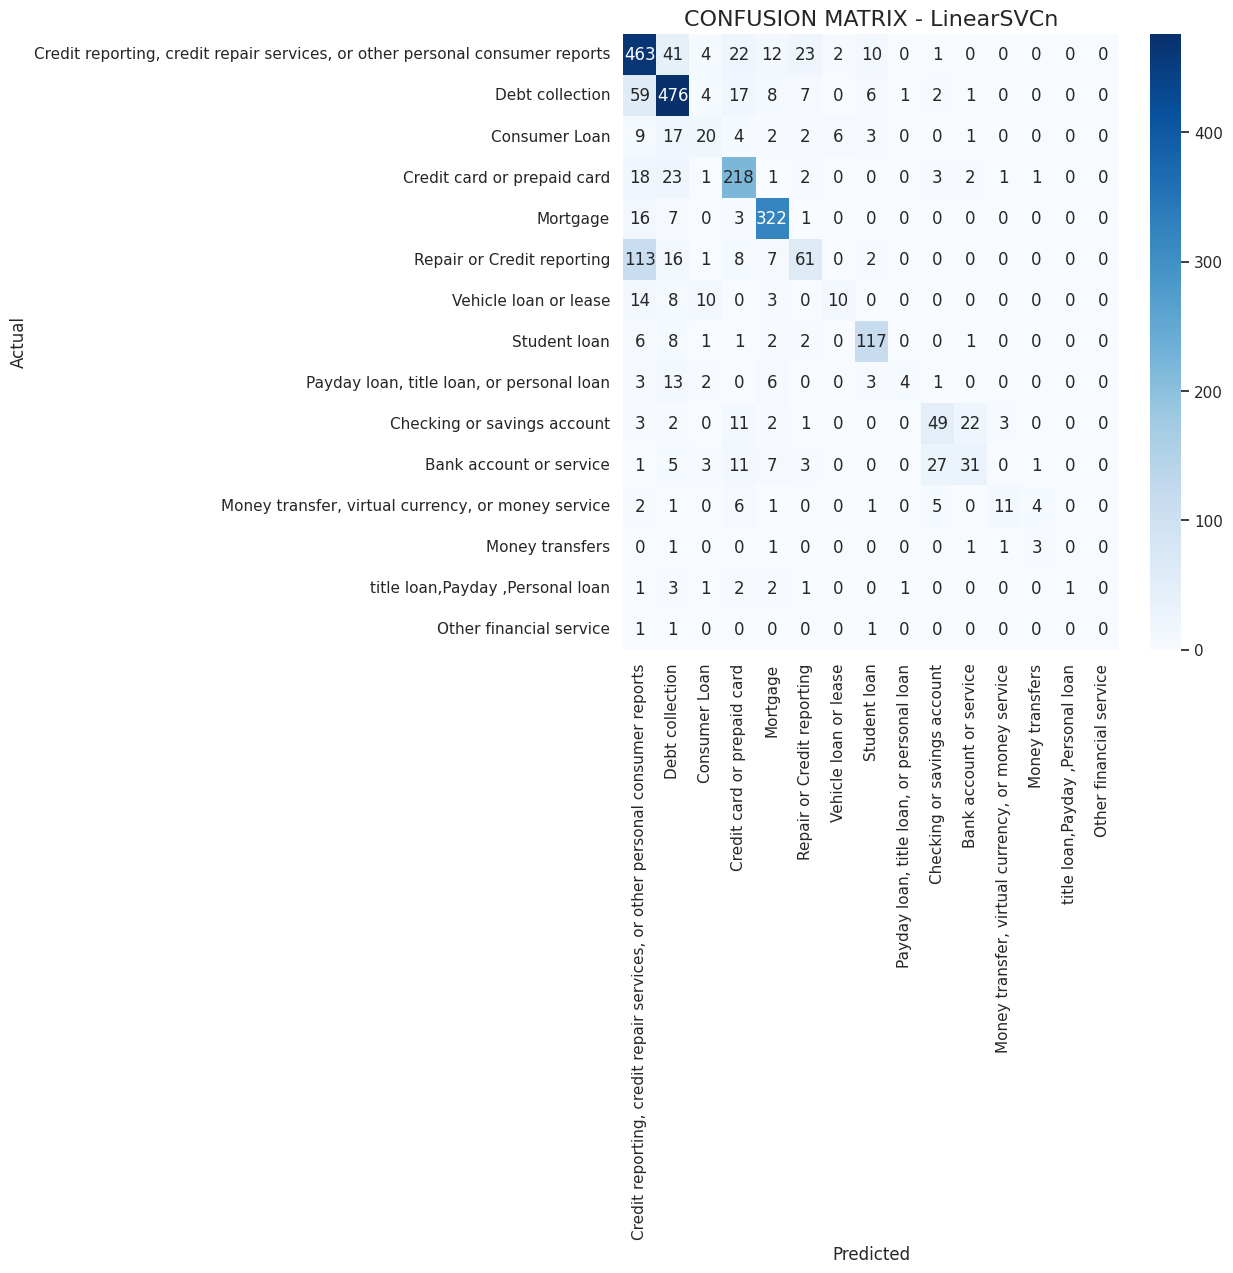

In [ ]:
import seaborn as sns
sns.set()
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id.Product.values,
            yticklabels=category_id.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVCn", size=16);


In [ ]:
complain = """I have been enrolled back in 2019 to Indian University. Few days ago , i have been harassed by
Navient. I have already faxed the paperwork providing them with everything they wanted. And still getting
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late for the payment. At this point,
Navient needs take their act together to avoid me taking further steps"""

In [ ]:
complaint_id = (model.predict(tfidf.transform([complain])))
print("complain", id_2_category[complaint_id[0]])

complain Student loan


In [ ]:
#https://www.kaggle.com/code/jagangupta/stop-the-s-toxic-comments-eda